## Yield Optimization via Hybrid ML-NumericalOptimzation for 1D Feature Space

In [2]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import layers
import tensorflow.keras


from scipy.optimize import minimize
import nevergrad as ng
from IPython.display import clear_output

from utils import function
import autokeras as ak

In [3]:
class TrainingPlot(tensorflow.keras.callbacks.Callback):
    
    # This function is called when the training begins
    def on_train_begin(self, logs={}):
        # Initialize the lists for holding the logs, losses and accuracies
        self.losses = []
        self.acc = []
        self.val_losses = []
        self.val_acc = []
        self.logs = []
    
    # This function is called at the end of each epoch
    def on_epoch_end(self, epoch, logs={}):
        
        # Append the logs, losses and accuracies to the lists
        self.logs.append(logs)
        self.losses.append(logs.get('loss'))
        self.acc.append(logs.get('mean_squared_error'))
        self.val_losses.append(logs.get('val_loss'))
        self.val_acc.append(logs.get('val_mean_squared_error'))
        
        # Before plotting ensure at least 2 epochs have passed
        if len(self.losses) > 1:
            
            # Clear the previous plot
            clear_output(wait=True)
            N = np.arange(0, len(self.losses))
            
            # You can chose the style of your preference
            # print(plt.style.available) to see the available options
            plt.style.use("seaborn")
            
            # Plot train loss, train acc, val loss and val acc against epochs passed
            #plt.figure()
            #subplot(nrows, ncols, plot_number) 
            plt.figure(figsize=(15,6))
            plt.subplot(121)
            plt.title("Training Loss [Epoch {}]".format(epoch))
            plt.plot(N, self.losses, label = "train_loss")
            plt.plot(N, self.val_losses, label = "val_loss")
            plt.xlabel("Epoch #")
            plt.ylabel("Loss")
            plt.legend()
            
            plt.subplot(122)
            plt.title("Training Accuracy [Epoch {}]".format(epoch))
            plt.plot(N, self.acc, label = "train_acc")
            plt.plot(N, self.val_acc, label = "val_acc")
            plt.xlabel("Epoch #")
            plt.ylabel("Accuracy")
            plt.legend()
            plt.show()

plot_losses = TrainingPlot()

In [23]:
# data = function.gen_regression_symbolic(m='-sin(3*X) - X**2 + 0.7*X', n_samples=1000, n_features=1, noise=0.0, noise_dist='normal')
# -(x+2)**2+2


bounds = np.array([[-1.0, 2.0]])
noise = 0.2

def f(X, noise=noise):
    return -np.sin(3*X) - X**2 + 0.7*X + noise * np.random.randn(*X.shape)

    # Dense grid of points within bounds
X = np.arange(bounds[:, 0], bounds[:, 1], 0.01).reshape(-1, 1)

# Noise-free objective function values at X 
Y = f(X,0)

In [31]:
type(X)

numpy.ndarray

## Data

In [33]:
df = pd.DataFrame(columns=['Temprerature','ProductionYield'], dtype=float)

In [36]:
df['Temprerature'] = X.reshape(-1, ) #data[:, 0]
df['ProductionYield'] = Y.reshape(-1, ) #data[:, 1]

df['Temprerature'] = df['Temprerature'].astype(float)
df['ProductionYield'] = df['ProductionYield'].astype(float)
# df['ProductionYield']= df['ProductionYield'].clip(0, 100)

In [37]:
print(df.head())

   Temprerature  ProductionYield
0         -1.00        -1.558880
1         -0.99        -1.502348
2         -0.98        -1.446170
3         -0.97        -1.390372
4         -0.96        -1.334981


In [38]:
df.describe()

,Temprerature,ProductionYield
count,300.000000,300.000000
mean,0.495000,-0.432079
std,0.867468,0.585952
min,-1.000000,-2.259009
25%,-0.252500,-0.824233
50%,0.495000,-0.395486
75%,1.242500,-0.088225
max,1.990000,0.500358


In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 2 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Temprerature     300 non-null    float64
 1   ProductionYield  300 non-null    float64
dtypes: float64(2)
memory usage: 4.8 KB


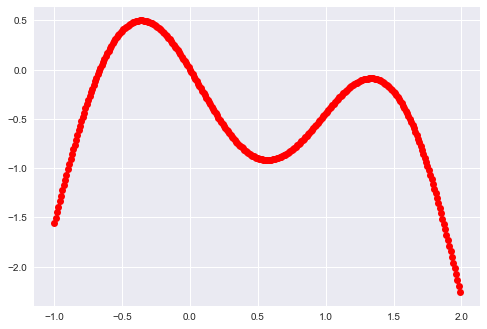

In [40]:
plt.plot(df['Temprerature'], df['ProductionYield'], 'ro')

## Prediction algorithm

In [41]:
# normalize the input data
X = df['Temprerature'].values
y = df['ProductionYield'].values

X_norm = X #(X - X.mean()) / X.std()
y_norm = y #(y - y.mean()) / y.std()


x_train, x_test, y_train, y_test = train_test_split(X_norm, y_norm, test_size=0.2, random_state=42)

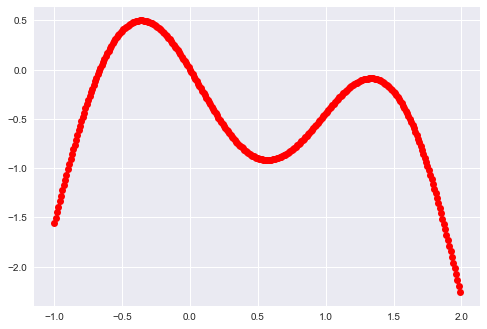

In [42]:
plt.plot(X_norm, y_norm, 'ro')

In [43]:
np.max(y_norm)

0.5003578068849475

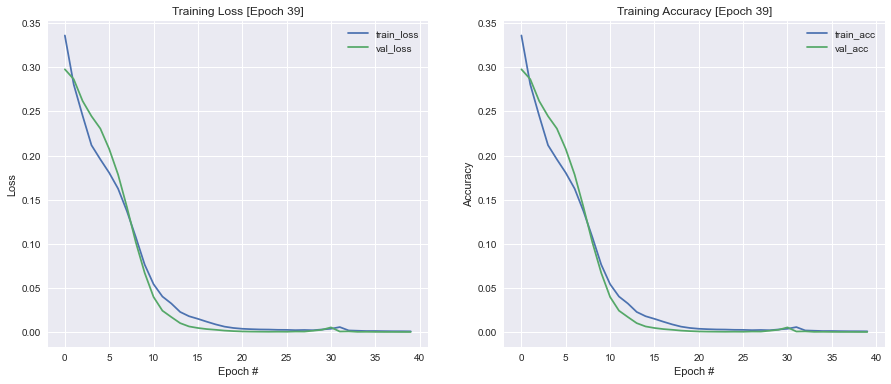

8/8 [==============================] - 1s 159ms/step - loss: 9.7371e-04 - mean_squared_error: 9.7371e-04 - val_loss: 2.6714e-04 - val_mean_squared_error: 2.6714e-04
INFO:tensorflow:Assets written to: .\structured_data_regressor\best_model\assets


In [49]:
# define the search
search = ak.StructuredDataRegressor(max_trials=10)

# perform the search
history =  search.fit(x=x_train.reshape(-1,1), 
                      y=y_train.reshape(-1,1),
                      validation_data= (x_test.reshape(-1,1), y_test.reshape(-1,1)),
                      callbacks=[plot_losses], 
                      epochs = 40,
                      verbose=1)

In [50]:
loss, acc = search.evaluate(x_test, y_test, verbose=1)
print('Accuracy: %.4f' % acc)

2/2 [==============================] - 0s 10ms/step - loss: 2.6714e-04 - mean_squared_error: 2.6714e-04
Accuracy: 0.0003


In [51]:
# get the best performing model
model = search.export_model()

# summarize the loaded model
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 multi_category_encoding (Mu  (None, 1)                0         
 ltiCategoryEncoding)                                            
                                                                 
 normalization (Normalizatio  (None, 1)                3         
 n)                                                              
                                                                 
 dense (Dense)               (None, 64)                128       
                                                                 
 re_lu (ReLU)                (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 1024)              66560 

In [52]:
from sklearn.metrics import r2_score
r2_score(y_test, model.predict(x_test))

0.9993143855813426

In [53]:
tp_indx = 4
print(f"real value: {y_test[tp_indx]}, model predicted: {model.predict(x_test[tp_indx].reshape(1,-1))}")

real value: -0.08767167177008128, model predicted: [[-0.102136]]


## Multi-dimensional optimization

### 'Nelder-Mead'

In [54]:
def wrapper(x, *args) -> float:
    
    network_input = x.reshape(1,-1)
    network_output = model.predict(network_input, *args)
    scipy_output = float(network_output)
    
    if (scipy_output > -100) & (scipy_output < 100):
        return -scipy_output
    
    else:
        return 10000000

In [59]:
x0 = 0
res = minimize(wrapper, x0, method='Nelder-Mead', tol=1e-6)

In [60]:
res

 final_simplex: (array([[-0.35678223],
       [-0.35678125]]), array([-0.49692279, -0.49692276]))
           fun: -0.4969227910041809
       message: 'Optimization terminated successfully.'
          nfev: 60
           nit: 29
        status: 0
       success: True
             x: array([-0.35678223])

In [61]:
res.x

array([-0.35678223])

In [62]:
model.predict(res.x.reshape(1,-1))

array([[0.4969228]], dtype=float32)

### Bound 'L-BFGS-B'

In [59]:
x0 = x_train[-5].reshape(1,-1)
bnds = ((-3, 3))
res = minimize(wrapper, x0, method='L-BFGS-B',bounds=None, tol=1e-6)

In [60]:
res

      fun: 1000000
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
      jac: array([0.])
  message: 'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 2
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([1.33825828])